# LAB 4 - CART

In this lab we will dive deeper into the `sklearn` package to make use of other statistical models such as classification and regression trees.

In [64]:
import numpy as np
import pandas as pd

Load the data

In [65]:
parole = pd.read_csv("NYCparole.csv")
parole.info()
parole.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6102 entries, 0 to 6101
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Violator    6102 non-null   int64  
 1   Male        6102 non-null   int64  
 2   Age         6102 non-null   float64
 3   TimeServed  6102 non-null   float64
 4   Class       6102 non-null   object 
 5   Multiple    6102 non-null   int64  
 6   InCity      6102 non-null   int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 333.8+ KB


,Violator,Male,Age,TimeServed,Class,Multiple,InCity
0,0,1,49.4,3.15,D,0,1
1,1,1,26.0,5.95,D,1,0
2,0,1,24.9,2.25,D,1,0
3,0,1,52.1,29.22,A,0,0
4,0,1,35.9,12.78,A,1,1


In [66]:
### Let's practice finding functions for things we don't already know how to do. 

# CART for classification with Parole data
# https://datascience.stackexchange.com/questions/6048/decision-tree-or-logistic-regression

## Categorical Variables

### Casting the response variable

In [67]:
parole['Violator'] = parole['Violator'].astype('int64')

### Dummy Encoding

In previous labs, we left the handling of categorical variables to the model.
With sklearn packages, we need to do the categorical encoding ourselves.

One type of encoding that we can use is called "Dummy Encoding". We will apply this to the `Class` variable

In [68]:
# parole = pd.get_dummies(parole, columns = ['Class'])
# parole.info()
# parole.head()

`pd.get_dummies()` can also automatically detect the categorical columns if no specific columns are given

### One-hot Encoding

In [69]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
encoding = ohe.fit_transform(parole['Class'].values.reshape(-1,1)).toarray()

encoding = pd.DataFrame(encoding, columns=["Class_"+str(int(i)) for i in range(encoding.shape[1])])
# [i for i in parole['Class'].unique()]

parole_enc = pd.concat([parole, encoding], axis=1)
parole_enc.drop(['Class'], axis=1, inplace=True)
parole_enc.head()

,Violator,Male,Age,TimeServed,Multiple,InCity,Class_0,Class_1,Class_2,Class_3,Class_4
0,0,1,49.4,3.15,0,1,0.0,0.0,0.0,1.0,0.0
1,1,1,26.0,5.95,1,0,0.0,0.0,0.0,1.0,0.0
2,0,1,24.9,2.25,1,0,0.0,0.0,0.0,1.0,0.0
3,0,1,52.1,29.22,0,0,1.0,0.0,0.0,0.0,0.0
4,0,1,35.9,12.78,1,1,1.0,0.0,0.0,0.0,0.0


## Splitting the Data

In [70]:
from sklearn.model_selection import train_test_split

y = parole_enc['Violator']
X = parole_enc.drop(['Violator'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=88, 
                                                    stratify=parole_enc['Violator'])
X_train.shape, X_test.shape

((4271, 10), (1831, 10))

In [71]:
# Baseline:
negative = np.sum(y_train == 0)
positive = np.sum(y_train == 1)
print(pd.Series({'0': negative, '1': positive}))

0    4037
1     234
dtype: int64


## Decision Tree Classifier

Now let's build a classification tree 

minbucket:  minimum number of observations per bucket

cp:         we can preset the cp before pruning if we know that we want that desired level of cp

In [72]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha=0.001,
                             random_state = 88)
mod = clf.fit(X_train, y_train)

### Plot the Tree

Node count = 17


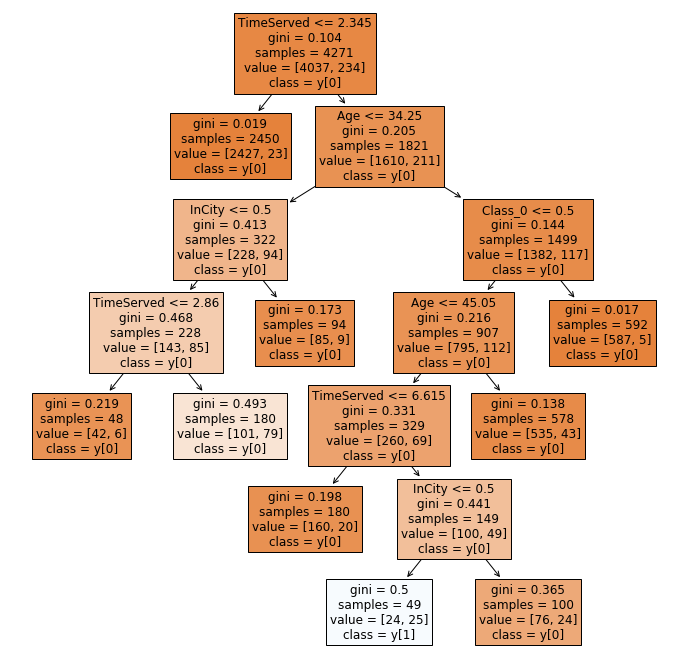

In [73]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

print('Node count =', mod.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(mod, feature_names=X_train.columns, class_names=True, filled=True, fontsize=12)
plt.show()

Node count = 5


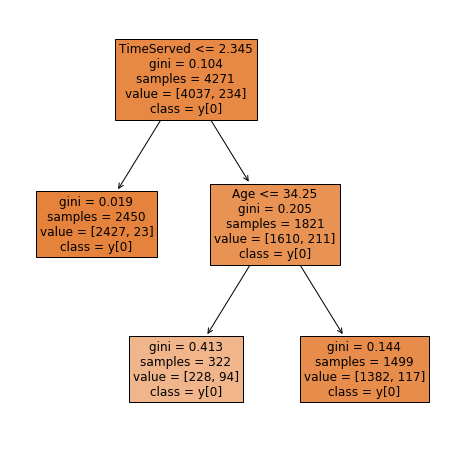

In [74]:
# Try pruning to get a smaller tree
clf = DecisionTreeClassifier(min_samples_leaf=5, 
                            ccp_alpha=0.005,
                            random_state = 88)
mod_small = clf.fit(X_train, y_train)

print('Node count =', mod_small.tree_.node_count)
plt.figure(figsize=(8,8))
plot_tree(mod_small, feature_names=X_train.columns, class_names=True, filled=True, fontsize=12)
plt.show()

## Confusion Matrix

In [75]:
# Make predictions 
from sklearn.metrics import confusion_matrix

y_pred = mod_small.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[1730    0]
 [ 101    0]]


## Custom Loss Function

In [76]:
# #     [,0] [,1]
# # [0,]    0    1
# # [1,]   20    0

# cost_tp = 0
# cost_tn = 0
# cost_fp = 1
# cost_fn = 20

# Explanation of weight use.

Node count = 11


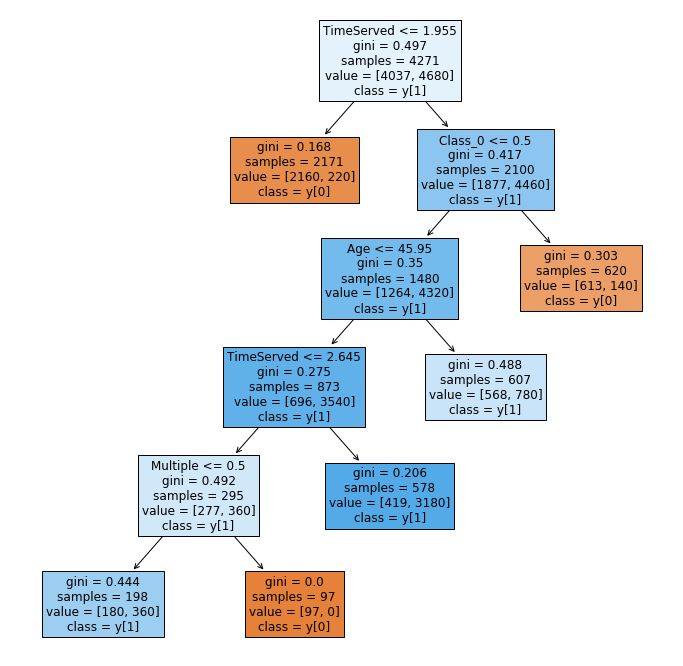

Confusion Matrix : 
 [[1239  491]
 [   7   94]]


In [77]:
clf = DecisionTreeClassifier(min_samples_leaf=5, 
                             ccp_alpha=0.007,
                             class_weight = {0: 1, 1: 20},
                             random_state = 88)
mod2 = clf.fit(X_train, y_train)

print('Node count =', mod2.tree_.node_count)
plt.figure(figsize=(12,12))
plot_tree(mod2, feature_names=X_train.columns, class_names=True, filled=True, fontsize=12)
plt.show()

y_pred = mod2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

## Regression Example

In [78]:
wine = pd.read_csv("../Lab1/wine_agg.csv")
wine.head()
len(wine)

46

In [79]:
wine_train = wine[wine['Year'] <= 1985]
wine_test = wine[wine['Year'] > 1985]

y_train = wine_train['LogAuctionIndex']
X_train = wine_train.drop(['LogAuctionIndex'], axis=1)
X_train.shape

(31, 8)

In [80]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(min_samples_split=10, 
                            ccp_alpha=0.02,
                            random_state = 88)
mod3 = clf.fit(X_train, y_train)

Node count = 9


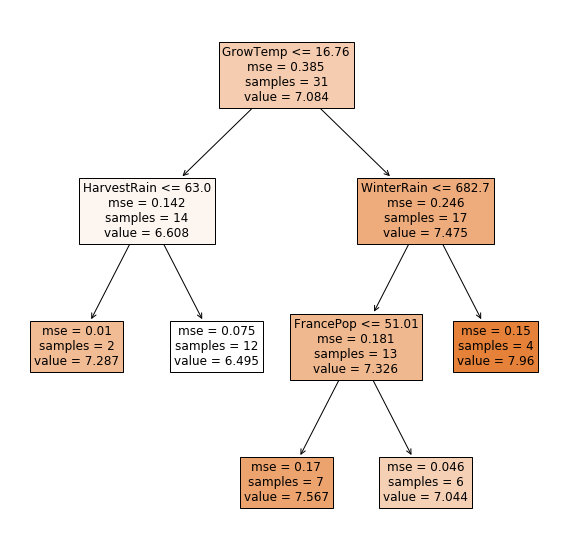

In [81]:
print('Node count =', mod3.tree_.node_count)
plt.figure(figsize=(10,10))
plot_tree(mod3, feature_names=X_train.columns, class_names=True, filled=True, fontsize=12)
plt.show()

In [82]:
y_test = wine_test['LogAuctionIndex']
X_test = wine_test.drop(['LogAuctionIndex'], axis=1)

y_pred = mod3.predict(X_test)
SSE = np.sum((y_test - y_pred)**2)
SST = np.sum((y_test - np.mean(y_train))**2)    
OSR2 =  1 - SSE/SST

print(OSR2)

-0.171331426511258


## Lab 4 Part 2

## Cross Validation

In [83]:
# https://en.wikipedia.org/wiki/Cross-validation_(statistics)
# First standard CV with respect to Accuracy, then the loss function

In [96]:
y = parole_enc['Violator']
X = parole_enc.drop(['Violator'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

In [85]:
from sklearn.model_selection import GridSearchCV

grid_values = {'ccp_alpha': np.linspace(0, 0.04, 11)}
               # 'criterion' : ['gini', 'entropy'],
               # 'max_depth' : [4, 5, 6]}

dt = DecisionTreeClassifier(random_state=88)
# default metric to optimize over grid parameters: accuracy. If none given.
clf_acc = GridSearchCV(dt, param_grid = grid_values, scoring = 'accuracy', cv=10)
clf_acc.fit(X_train, y_train)

clf_acc.cv_results_

{'mean_fit_time': array([0.0110832 , 0.01115797, 0.01282454, 0.00994279, 0.00978501,
        0.00978622, 0.00983582, 0.01025918, 0.00977564, 0.00976901,
        0.009776  ]),
 'std_fit_time': array([0.00160411, 0.00147211, 0.00258525, 0.00061357, 0.00036089,
        0.00027772, 0.00027091, 0.00151432, 0.00032954, 0.00042218,
        0.00027854]),
 'mean_score_time': array([0.00259683, 0.00270424, 0.00310717, 0.00236852, 0.00232599,
        0.00227959, 0.00249276, 0.00231521, 0.00230205, 0.00230138,
        0.00229573]),
 'std_score_time': array([2.84396739e-04, 5.07107353e-04, 7.10516697e-04, 1.51964458e-04,
        1.19835897e-04, 6.88408246e-05, 4.85248118e-04, 1.58754768e-04,
        1.07173341e-04, 1.28383039e-04, 1.03713671e-04]),
 'param_ccp_alpha': masked_array(data=[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028,
                    0.032, 0.036000000000000004, 0.04],
              mask=[False, False, False, False, False, False, False, False,
                    False, Fal

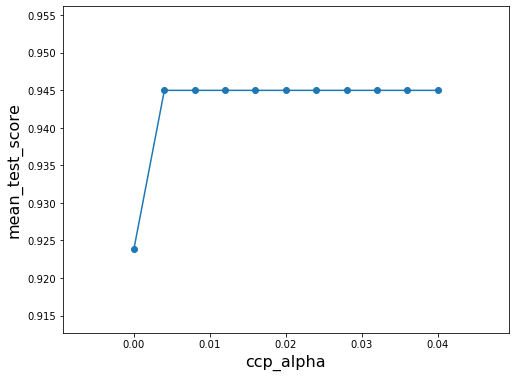

In [86]:
x = clf_acc.cv_results_['param_ccp_alpha'].data
y = clf_acc.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('mean_test_score', fontsize=16)
plt.scatter(x, y)
plt.plot(x, y)
plt.show()

In [87]:
print('Grid best parameter (max. accuracy): ', clf_acc.best_params_)
print('Grid best score (accuracy): ', clf_acc.best_score_)

Grid best parameter (max. accuracy):  {'ccp_alpha': 0.004}
Grid best score (accuracy):  0.9449780034581629


Node count = 5


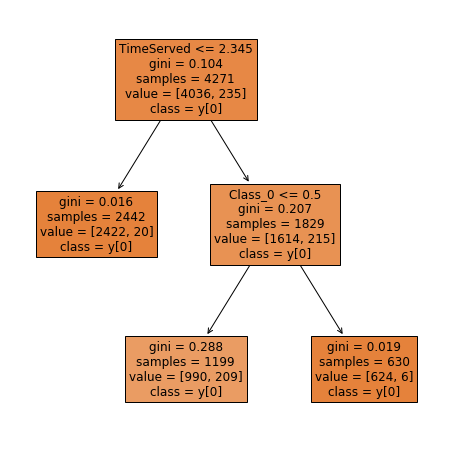

In [88]:
print('Node count =', clf_acc.best_estimator_.tree_.node_count)

plt.figure(figsize=(8,8))
plot_tree(clf_acc.best_estimator_, feature_names=X_train.columns, class_names=True, filled=True, fontsize=12)
plt.show()

In [89]:
y_pred = clf_acc.predict(X_test) # same as: y_pred = clf_acc.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[1731    0]
 [ 100    0]]


## Alternative Metrics for Cross-Validation

In [90]:
# Alternative metric to optimize over grid parameters: AUC
# from sklearn.metrics import roc_auc_score

clf_auc = GridSearchCV(dt, param_grid = grid_values, scoring = 'roc_auc', cv=10)
clf_auc.fit(X_train, y_train)

# print('Test set AUC: ', roc_auc_score(y_test, clf_auc.predict_proba(X_test)[:,1]))
print('Grid best parameter (max. AUC): ', clf_auc.best_params_)
print('Grid best score (AUC): ', clf_auc.best_score_)

Grid best parameter (max. AUC):  {'ccp_alpha': 0.004}
Grid best score (AUC):  0.8051503843946268


In [91]:
y_pred = clf_auc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[1731    0]
 [ 100    0]]


## Cross-validation on CART with Loss Function

In [97]:
dt = DecisionTreeClassifier(class_weight = {0: 1, 1: 20})
clf_acc2 = GridSearchCV(dt, param_grid = grid_values, scoring = 'accuracy', cv=10)
clf_acc2.fit(X_train, y_train)

# clf_acc2.cv_results_

GridSearchCV(cv=10,
             estimator=DecisionTreeClassifier(class_weight={0: 1, 1: 20}),
             param_grid={'ccp_alpha': array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
       0.036, 0.04 ])},
             scoring='accuracy')

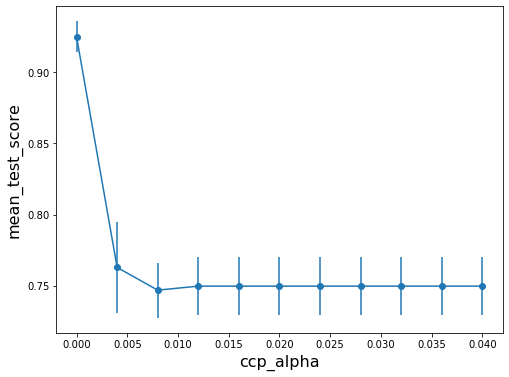

In [98]:
x = clf_acc2.cv_results_['param_ccp_alpha'].data
y = clf_acc2.cv_results_['mean_test_score']
y_std = clf_acc2.cv_results_['std_test_score']
# lower_error = y-clf_acc2.cv_results_['std_test_score']
# upper_error = y+clf_acc2.cv_results_['std_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('mean_test_score', fontsize=16)
plt.errorbar(x, y, y_std, fmt='-o')
plt.show()

Node count = 683


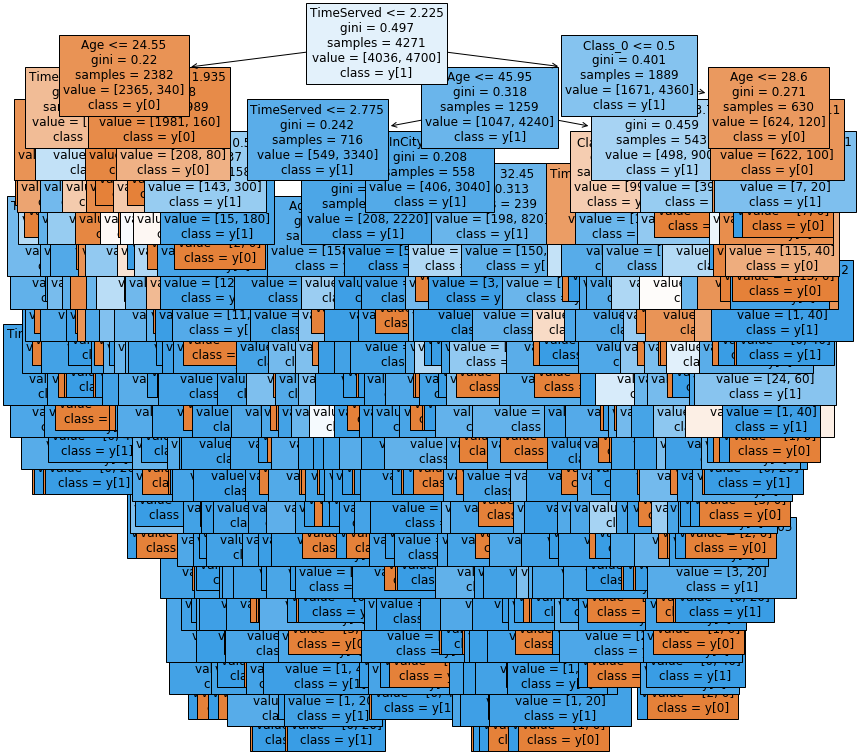

In [99]:
print('Node count =', clf_acc2.best_estimator_.tree_.node_count)

plt.figure(figsize=(13,13))
plot_tree(clf_acc2.best_estimator_, feature_names=X_train.columns, class_names=True, filled=True, fontsize=12)
plt.show()

In [95]:
y_pred = clf_acc2.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[1661   70]
 [  71   29]]
